# Import dependencies

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, Conv1D, BatchNormalization, LeakyReLU, Conv1DTranspose, Flatten, Reshape

In [2]:
from collections import Counter

# Load & prepare data

In [2]:
# RUN ONCE
train_data = []
for inx in tqdm(range(4282)):
    embeddings_data = pd.read_csv(f"D:/documents/lambda_calc_data/embeddings_4k/term_embeddings_{inx}.csv").drop(
        columns=['Unnamed: 0'])
    train_data.append(embeddings_data.to_numpy())

100%|██████████| 4282/4282 [03:54<00:00, 18.27it/s]


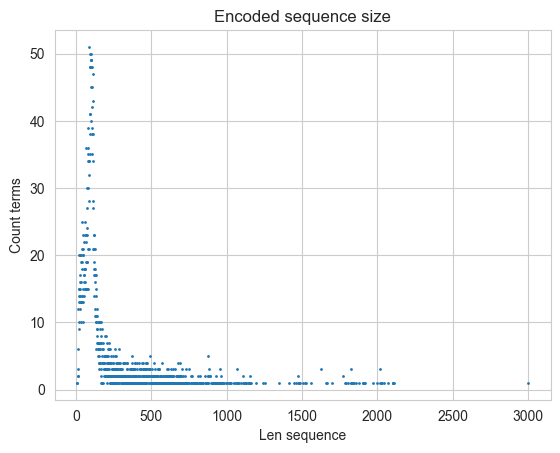

In [25]:
# RUN ONCE
list_counts = []
for inx in range(len(train_data)):
    list_counts.append(train_data[inx].shape[0])

list_counts = dict(Counter(list_counts))

plt.scatter(sorted(list_counts), [list_counts[inx] for inx in sorted(list_counts)], s=19)
plt.xlabel("Len sequence")
plt.ylabel("Count terms")
plt.title("Encoded sequence size")
plt.show()

In [2]:
def pad_trunc(data, target_size):
    if data.shape[0] < target_size:
        padded_data = np.pad(data, ((0, target_size - data.shape[0]), (0, 0)), mode='constant', constant_values=0.0)
        return padded_data
    elif data.shape[0] > target_size:
        truncated_data = data[:target_size, :]
        return truncated_data
    else:
        return data


train_data = []
for inx in tqdm(range(4282)):
    embeddings_data = pd.read_csv(f"D:/documents/lambda_calc_data/embeddings_4k/term_embeddings_{inx}.csv").drop(
        columns=['Unnamed: 0'])
    train_data.append(pad_trunc(embeddings_data.to_numpy(), 500))

100%|██████████████████████████████████████████████████████████████████████████████| 4282/4282 [02:56<00:00, 24.32it/s]


In [12]:
batch_size = 25
epochs = 50


def train_generator():
    num_batches = len(train_data) // batch_size
    indexes = np.arange(len(train_data))
    while True:
        np.random.shuffle(indexes)
        inx_batches = np.array_split(indexes, num_batches)
        for inx_batch in inx_batches:
            batch = np.array([train_data[inx] for inx in list(inx_batch)])
            yield batch, batch


def data_generator():
    while True:
        for sample in train_data:
            yield np.array([sample, ])

In [11]:
all_data = pd.read_csv(
    "../tests_17_ann_and_terms/article_v2_2_term_var_to_best_strategy/prepare_data/data_steps/steps_vars_term_str.csv",
    delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

# RI == LO -> 0
# RI > LO -> 1
# RI < LO -> 2
class_RI_LO = ["RI = LO" if los == ris else "RI < LO" if ris < los else "LO < RI" for los, ris in
               zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]

print(f"Count terms data samples: {len(class_RI_LO)}")

Count all terms: 4282
max RI steps count: 1000
max LO steps count: 219
Count terms data samples: 4282


# Define & train autoencoder model

In [4]:
class Autoencoder(Model):
    def __init__(self, latent_dim=2, shape=(500, 768)):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            Input(shape=shape, name="encoder_input"),

            # Block 1
            Conv1D(filters=128, kernel_size=3, strides=1, padding="same", name="enc_conv_1"),
            BatchNormalization(name="enc_bn_1"),
            LeakyReLU(name="enc_lrelu_1"),

            # Block 2
            Conv1D(filters=64, kernel_size=3, strides=2, padding="valid", name="enc_conv_2"),
            BatchNormalization(name="enc_bn_2"),
            LeakyReLU(name="enc_lrelu_2"),

            # Block 3
            Conv1D(filters=64, kernel_size=3, strides=2, padding="valid", name="enc_conv_3"),
            BatchNormalization(name="enc_bn_3"),
            LeakyReLU(name="enc_lrelu_3"),

            # Block 4
            Conv1D(filters=32, kernel_size=3, strides=2, padding="valid", name="enc_conv_4"),
            BatchNormalization(name="enc_bn_4"),
            LeakyReLU(name="enc_lrelu_4"),

            Flatten(),
            Dense(2, name='dense_1'),
        ], name="encoder")

        self.decoder = tf.keras.Sequential([
            Input(shape=2, name="decoder_input"),
            Dense(units=4000, name="dec_dense_1"),
            Reshape(target_shape=[500, 8], name="dec_reshape"),

            # Block 1
            Conv1DTranspose(filters=16, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_1"),
            BatchNormalization(name='dec_bn_1'),
            LeakyReLU(name='dec_lrelu_1'),

            # Block 2
            Conv1DTranspose(filters=64, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_2"),
            BatchNormalization(name='dec_bn_2'),
            LeakyReLU(name='dec_lrelu_2'),

            # Block 3
            Conv1DTranspose(filters=128, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_3"),
            BatchNormalization(name='dec_bn_3'),
            LeakyReLU(name='dec_lrelu_3'),

            Conv1DTranspose(filters=768, kernel_size=3, strides=1, padding="same", activation="sigmoid",
                            name="dec_conv_transpose_4"),
        ], name="decoder")

    def call(self, inputs, training=None, mask=None):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
autoencoder_model = Autoencoder()
autoencoder_model.compile(optimizer='adam', loss=tf.losses.MeanSquaredError())

In [19]:
autoencoder_model.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_conv_1 (Conv1D)         (None, 500, 128)          295040    
                                                                 
 enc_bn_1 (BatchNormalizatio  (None, 500, 128)         512       
 n)                                                              
                                                                 
 enc_lrelu_1 (LeakyReLU)     (None, 500, 128)          0         
                                                                 
 enc_conv_2 (Conv1D)         (None, 249, 64)           24640     
                                                                 
 enc_bn_2 (BatchNormalizatio  (None, 249, 64)          256       
 n)                                                              
                                                                 
 enc_lrelu_2 (LeakyReLU)     (None, 249, 64)           0   

In [20]:
autoencoder_model.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dec_dense_1 (Dense)         (None, 4000)              12000     
                                                                 
 dec_reshape (Reshape)       (None, 500, 8)            0         
                                                                 
 dec_conv_transpose_1 (Conv1  (None, 500, 16)          400       
 DTranspose)                                                     
                                                                 
 dec_bn_1 (BatchNormalizatio  (None, 500, 16)          64        
 n)                                                              
                                                                 
 dec_lrelu_1 (LeakyReLU)     (None, 500, 16)           0         
                                                                 
 dec_conv_transpose_2 (Conv1  (None, 500, 64)          3136

In [6]:
print("ENC IN:", autoencoder_model.encoder.inputs)
print("ENC OUT:", autoencoder_model.encoder.outputs, "\n")
print("DEC IN:", autoencoder_model.decoder.inputs)
print("DEC OUT:", autoencoder_model.decoder.outputs)

ENC IN: [<KerasTensor: shape=(None, 500, 768) dtype=float32 (created by layer 'encoder_input')>]
ENC OUT: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_1')>] 

DEC IN: [<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'decoder_input')>]
DEC OUT: [<KerasTensor: shape=(None, 500, 768) dtype=float32 (created by layer 'dec_conv_transpose_4')>]


In [7]:
history = autoencoder_model.fit(
    train_generator(), 
    steps_per_epoch=(len(train_data) // batch_size) + 1, 
    epochs=epochs,
    verbose=1,
)

Epoch 1/50
172/172 [==============================] - 13s 61ms/step - loss: 0.1512
Epoch 2/50
172/172 [==============================] - 10s 59ms/step - loss: 0.1296
Epoch 3/50
172/172 [==============================] - 9s 50ms/step - loss: 0.1276
Epoch 4/50
172/172 [==============================] - 9s 51ms/step - loss: 0.1278
Epoch 5/50
172/172 [==============================] - 9s 50ms/step - loss: 0.1270
Epoch 6/50
172/172 [==============================] - 9s 50ms/step - loss: 0.1280
Epoch 7/50
172/172 [==============================] - 9s 51ms/step - loss: 0.1270
Epoch 8/50
172/172 [==============================] - 9s 50ms/step - loss: 0.1272
Epoch 9/50
172/172 [==============================] - 9s 51ms/step - loss: 0.1275
Epoch 10/50
172/172 [==============================] - 9s 50ms/step - loss: 0.1263
Epoch 11/50
172/172 [==============================] - 9s 50ms/step - loss: 0.1268
Epoch 12/50
172/172 [==============================] - 9s 50ms/step - loss: 0.1271
Epoch 13/50

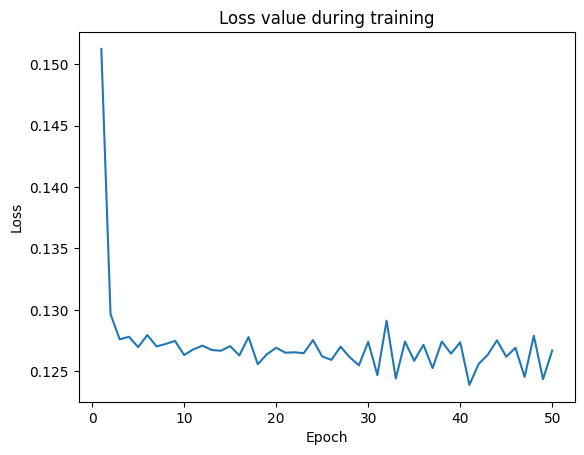

In [10]:
plt.plot(range(1, epochs+1), history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss value during training")
plt.show()

# Additional testings

In [14]:
encoded_embeddings = autoencoder_model.encoder.predict(data_generator(), steps=4282)

4282/4282 [==============================] - 15s 3ms/step


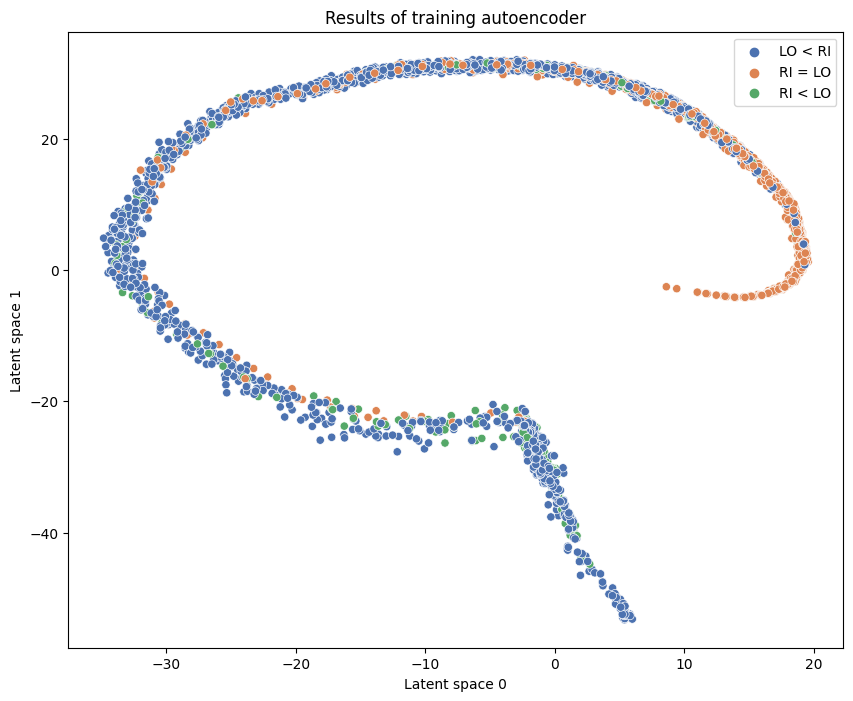

In [18]:
list_ls_0 = [ee[0] for ee in encoded_embeddings]
list_ls_1 = [ee[1] for ee in encoded_embeddings]

encoding_df = pd.DataFrame()
encoding_df["LS0"] = list_ls_0
encoding_df["LS1"] = list_ls_1
encoding_df["class"] = class_RI_LO


plt.figure(figsize=(10, 8))
sns.scatterplot(x='LS0', y='LS1', hue='class', data=encoding_df, palette="deep")
plt.title('Results of training autoencoder')
plt.xlabel('Latent space 0')
plt.ylabel('Latent space 1')
plt.legend()
plt.show()